In [1]:
pwd

'/home/gdolle/code/G-Dolle/DIVVY_BIKE/notebooks'

In [2]:
cd '/home/gdolle/code/G-Dolle/DIVVY_BIKE'

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [3]:
import os
import pandas as pd

from divvy.ml_logic.data_import import get_divvy_data, get_weather_data
from divvy.ml_logic.cleaning import compute_geohash_stations,weather_cleaning, cleaning_divvy_gen,cleaning_divvy_gen_agg, merge_divvy_weather, features_target
from divvy.ml_logic.preprocessor import transform_time_features, preprocess_features, target_process



In [4]:
raw_weather_df = get_weather_data()
clean_weather_df = weather_cleaning(raw_weather_df)

divvy_q1_2021 = get_divvy_data(2021,"Q1")

divvy_q2_2021 = get_divvy_data(2021,"Q2")
divvy_q3_2021 = get_divvy_data(2021,"Q3")
divvy_q4_2021 = get_divvy_data(2021,"Q4")


In [5]:
#divvy_jan_2021 = pd.read_csv("raw_data/2021/202101-divvy-tripdata.csv")
#divvy_feb_2021 = pd.read_csv("raw_data/2021/202102-divvy-tripdata.csv")
#divvy_mar_2021 = pd.read_csv("raw_data/2021/202103-divvy-tripdata.csv")

In [6]:
#divvy_q1_2021 = pd.concat([divvy_jan_2021, divvy_feb_2021,divvy_mar_2021])
#divvy_q1_2021.to_csv("raw_data/2021/Divvy_Trips_2021_Q1.csv", index=False)

In [7]:
rides_df = pd.concat([divvy_q1_2021,divvy_q2_2021, divvy_q3_2021,divvy_q4_2021])

rides_df = rides_df[rides_df["start_station_name"].isnull()==False]
rides_df['started_at']=pd.to_datetime(rides_df['started_at'])
rides_df['hourly_data_started'] = rides_df.started_at.dt.round('60min')

rides_df = rides_df[["start_station_name","ride_id","hourly_data_started"]]
rides_df.rename(columns={"start_station_name":"station_name"}, inplace=True)


precision_level= int(os.environ.get("PRECISION_LEVEL"))
geohash_station_df = compute_geohash_stations(precision = precision_level)

rides_df = rides_df.merge(geohash_station_df, on="station_name", how="left")

rides_df["date"]= pd.to_datetime(rides_df["hourly_data_started"]).dt.date
rides_df["nb_rides"]=1

rides_df_daily_geohash = rides_df.groupby(by=["geohash","date"])["nb_rides"].sum().reset_index()
rides_df_daily = rides_df.groupby(by=["date"])["nb_rides"].sum().reset_index()

/home/gdolle/code/G-Dolle/DIVVY_BIKE/divvy/ml_logic/cleaning.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [8]:
rides_df_daily.head(5)

,date,nb_rides
0,2021-01-01,948
1,2021-01-02,2086
2,2021-01-03,2236
3,2021-01-04,2946
4,2021-01-05,3539


In [9]:
rides_df_daily.shape

(366, 2)

In [10]:
rides_df_daily_geohash.head(5)

,geohash,date,nb_rides
0,dp3sy,2021-03-10,1
1,dp3sy,2021-03-15,1
2,dp3sy,2021-03-20,1
3,dp3sy,2021-03-21,1
4,dp3sy,2021-03-22,2


In [11]:
rides_df_daily_geohash.shape

(12585, 3)

In [12]:
clean_weather_df["date"]= pd.to_datetime(clean_weather_df["hourly_data"]).dt.date
avg_weather_df = clean_weather_df.groupby(by=["date"])["temp",
                                                    "pressure",
                                                    'humidity',
                                                    'wind_speed',
                                                    'wind_deg',
                                                    "clouds_all"].mean().reset_index()

/tmp/ipykernel_30586/3525036496.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_weather_df = clean_weather_df.groupby(by=["date"])["temp",


In [13]:
avg_weather_df.head(5)

,date,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,2013-01-01,-5.561667,1020.791667,55.458333,3.826250,313.333333,65.833333
1,2013-01-02,-6.889583,1021.875000,53.291667,3.509583,245.000000,22.916667
2,2013-01-03,-3.463750,1020.750000,67.250000,5.002083,243.333333,76.458333
3,2013-01-04,-4.640833,1023.541667,66.458333,6.167917,249.166667,12.291667
4,2013-01-05,-1.201250,1022.083333,71.166667,4.327083,217.083333,30.000000


In [14]:
rides_df_daily_geohash.to_csv("raw_data/rides_df_daily_geohash_2021.csv", index=False)

rides_df_daily.to_csv("raw_data/rides_df_daily_2021.csv", index=False)
avg_weather_df.to_csv("raw_data/avg_temp.csv", index=False)

In [15]:
import matplotlib.pyplot as plt

In [51]:
def timeframe_df(df,timevariable,start_time,end_time):

    condition_1 = df[timevariable] >= pd.to_datetime(start_time)
    condition_2 = df[timevariable] <= pd.to_datetime(end_time)

    df_red = df[condition_1]
    df_red = df_red[condition_2]

    return df_red

def plot_rides_geohash(start_time,end_time,df_divvy,
                       df_weather,timevariable,
                       geohash,weather_metric):

    df_divvy_red = timeframe_df(df_divvy,timevariable,start_time,end_time)
    df_weather_red = timeframe_df(df_weather,timevariable,start_time,end_time)

    df_divvy_red = df_divvy_red[df_divvy_red["geohash"]==geohash]
    df_weather_red = df_weather_red[[timevariable,weather_metric]]

    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(df_divvy_red[timevariable],df_divvy_red.nb_rides, 'g-')
    ax2.plot(df_weather_red[timevariable],df_weather_red[weather_metric], 'b-')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Total nb of rides per day', color='g')
    ax2.set_ylabel(f'{weather_metric}', color='b')

    return fig


def plot_rides_all(start_time,end_time,df_divvy,
                       df_weather,timevariable,
                       weather_metric):

    df_divvy_red = timeframe_df(df_divvy,timevariable,start_time,end_time)
    df_weather_red = timeframe_df(df_weather,timevariable,start_time,end_time)

    df_weather_red = df_weather_red[[timevariable,weather_metric]]

    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(df_divvy_red[timevariable],df_divvy_red.nb_rides, 'g-')
    ax2.plot(df_weather_red[timevariable],df_weather_red[weather_metric], 'b-')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Total nb of rides per day', color='g')
    ax2.set_ylabel(f'{weather_metric}', color='b')

    return fig

In [17]:
start_time = "2021-01-01"
end_time = "2021-12-31"
timevariable="date"
geohash = "dp3wm"
weather_metric="temp"

/tmp/ipykernel_30586/921158818.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  condition_1 = df[timevariable] >= pd.to_datetime(start_time)
/tmp/ipykernel_30586/921158818.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  condition_2 = df[timevariable] <= pd.to_datetime(end_time)
/tmp/ipykernel_30586/921158818.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_red = df_red[condition_2]


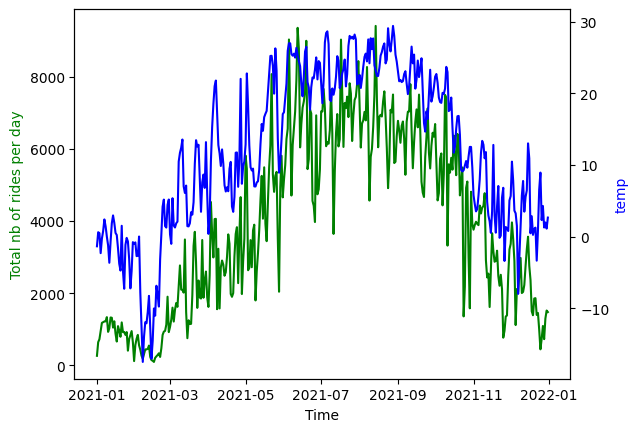

In [18]:
fig=plot_rides_geohash(start_time,end_time,
                       rides_df_daily_geohash,avg_weather_df,
                       timevariable,geohash,
                       weather_metric)


/tmp/ipykernel_30586/4043943131.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  condition_1 = df[timevariable] >= pd.to_datetime(start_time)
/tmp/ipykernel_30586/4043943131.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  condition_2 = df[timevariable] <= pd.to_datetime(end_time)
/tmp/ipykernel_30586/4043943131.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_red = df_red[condition_2]


AttributeError: 'AxesSubplot' object has no attribute 'sns'

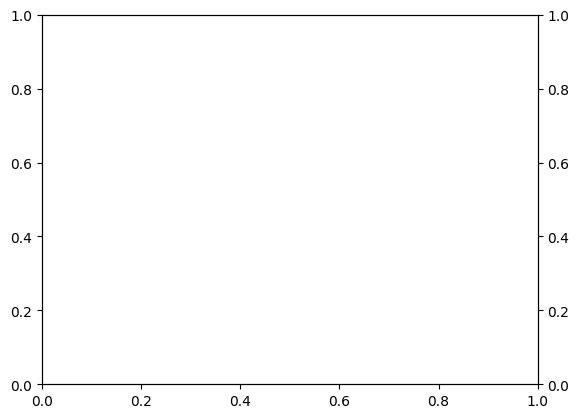

In [52]:
fig2=plot_rides_all(start_time,end_time,
                       rides_df_daily,avg_weather_df,
                       timevariable,
                       weather_metric)

In [20]:
avg_weather_df.columns

Index(['date', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'clouds_all'],
      dtype='object')

In [21]:
rides_df_daily = rides_df_daily.merge(avg_weather_df, on="date", how="left")


In [22]:
rides_df_daily.head()

,date,nb_rides,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,2021-01-01,948,-1.328750,1021.875000,82.541667,7.308333,95.416667,85.208333
1,2021-01-02,2086,0.635417,1016.125000,89.541667,7.054167,279.583333,100.000000
2,2021-01-03,2236,0.512917,1015.458333,90.208333,4.433333,234.583333,100.000000
3,2021-01-04,2946,-2.283750,1016.375000,88.500000,6.129167,206.250000,100.000000
4,2021-01-05,3539,-0.260417,1017.375000,86.875000,5.125000,287.500000,95.416667


In [23]:
rides_df_daily["quarter"]= pd.to_datetime(rides_df_daily["date"]).dt.quarter 
rides_df_daily.quarter.value_counts()

3    92
4    92
1    91
2    91
Name: quarter, dtype: int64

In [24]:
rides_df_quarterly = rides_df_daily.groupby(by=["quarter"])["nb_rides","temp"].mean().reset_index()
rides_df_quarterly

/tmp/ipykernel_30586/1594237106.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rides_df_quarterly = rides_df_daily.groupby(by=["quarter"])["nb_rides","temp"].mean().reset_index()


,quarter,nb_rides,temp
0,1,3818.483516,-0.052587
1,2,15806.494505,16.417999
2,3,22979.315217,23.516445
3,4,10916.130435,8.173139


In [25]:
rides_df_quarterly_1=rides_df_quarterly[["quarter","nb_rides"]]
rides_df_quarterly_1.rename(columns={"nb_rides":"value"}, inplace=True)
rides_df_quarterly_1["metric"]="nb_rides"

rides_df_quarterly_2=rides_df_quarterly[["quarter","temp"]]
rides_df_quarterly_2.rename(columns={"temp":"value"}, inplace=True)
rides_df_quarterly_2["metric"]="temp"


rides_df_Q_long = pd.concat([rides_df_quarterly_1,rides_df_quarterly_2])
rides_df_Q_long

/tmp/ipykernel_30586/774654409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_df_quarterly_1.rename(columns={"nb_rides":"value"}, inplace=True)
/tmp/ipykernel_30586/774654409.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_df_quarterly_2.rename(columns={"temp":"value"}, inplace=True)


,quarter,value,metric
0,1,3818.483516,nb_rides
1,2,15806.494505,nb_rides
2,3,22979.315217,nb_rides
3,4,10916.130435,nb_rides
0,1,-0.052587,temp
1,2,16.417999,temp
2,3,23.516445,temp
3,4,8.173139,temp


<AxesSubplot: xlabel='quarter', ylabel='value'>

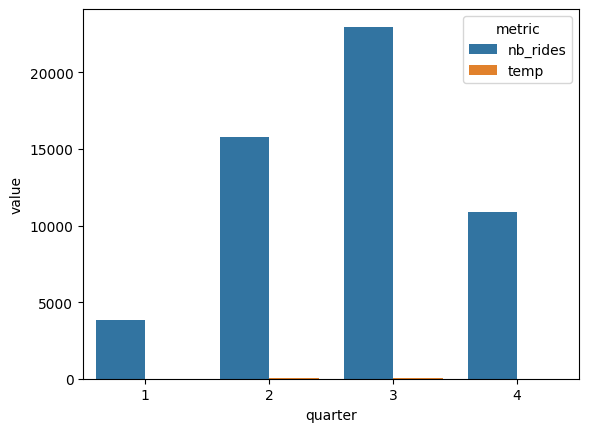

In [26]:
import seaborn as sns

sns.barplot(data=rides_df_Q_long, x="quarter", y="value", hue="metric")


In [27]:
import numpy as np

In [39]:
rides_df_daily["nb_rides"] = rides_df_daily["nb_rides"]/1000

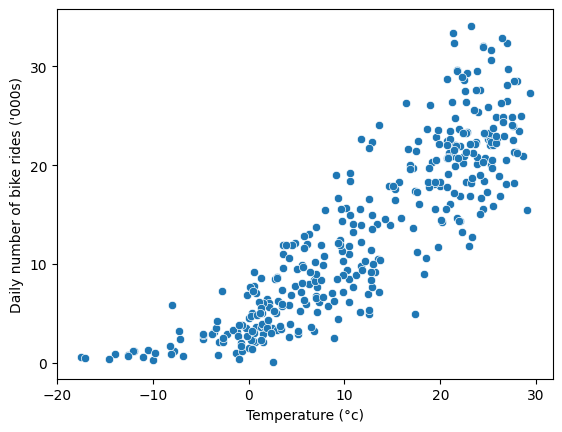

In [49]:
figure_ = sns.scatterplot(data = rides_df_daily, x="temp",y="nb_rides")
figure_.set_xlabel("Temperature (°c)")
figure_.set_ylabel("Daily number of bike rides ('000s)")
figure_.set_xticks(range(-20,35,10))
figure_.set_yticks(range(0,40,10))


In [50]:
figure_.figure.savefig("raw_data/output.png")

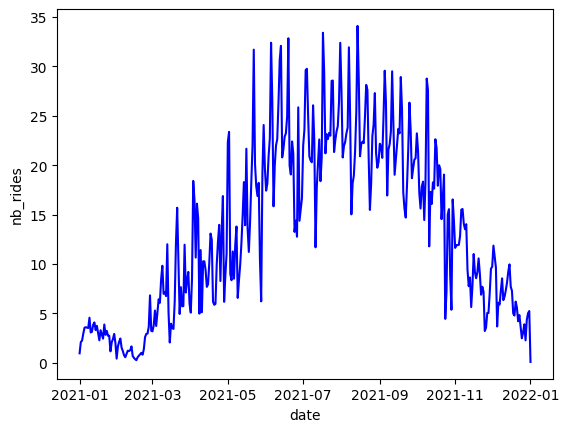

In [63]:
ax1 = sns.lineplot(data=rides_df_daily, x=timevariable,y="nb_rides", color='b')

In [65]:
rides_df_MA = rides_df_daily.copy()

In [74]:
rides_df_MA['nb_rides_MA3'] = rides_df_MA['nb_rides'].rolling(7).mean()
rides_df_MA['temp_MA3'] = rides_df_MA['temp'].rolling(7).mean()

Text(0, 0.5, 'Temperature (°c)')

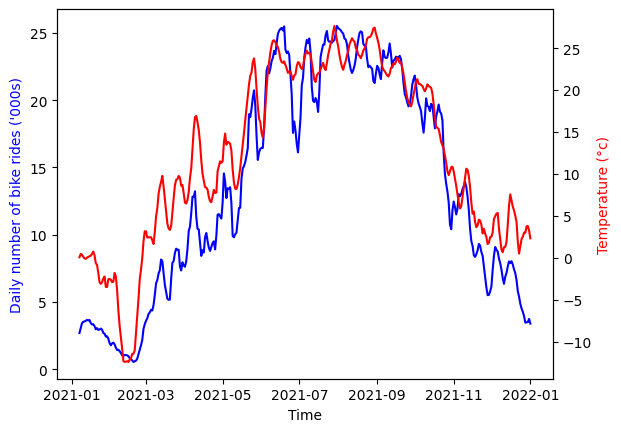

In [98]:
palette = sns.set_palette("pastel")

ax1 = sns.lineplot(data=rides_df_MA, x=timevariable,y="nb_rides_MA3", color='b', legend=True)
ax2 = ax1.twinx()
sns.lineplot(data=rides_df_MA, x=timevariable,y="temp_MA3", color='r', ax=ax2,  legend=True)

ax1.set_xlabel('Time')
ax1.set_ylabel("Daily number of bike rides ('000s)", color='b')
ax2.set_ylabel('Temperature (°c)', color='r')


In [100]:
pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 12.4 MB/s eta 0:00:0000:0100:01
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
Note: you may need to restart the kernel to use updated packages.


In [103]:
rides_df_daily["date"]= pd.to_datetime(rides_df_daily["date"])
rides_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        366 non-null    datetime64[ns]
 1   nb_rides    366 non-null    float64       
 2   temp        366 non-null    float64       
 3   pressure    366 non-null    float64       
 4   humidity    366 non-null    float64       
 5   wind_speed  366 non-null    float64       
 6   wind_deg    366 non-null    float64       
 7   clouds_all  366 non-null    float64       
 8   quarter     366 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 28.6 KB


In [114]:
rides_df_daily.head(5)

,nb_rides,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,quarter
date,,,,,,,,
2021-01-01,0.948,-1.328750,1021.875000,82.541667,7.308333,95.416667,85.208333,1
2021-01-02,2.086,0.635417,1016.125000,89.541667,7.054167,279.583333,100.000000,1
2021-01-03,2.236,0.512917,1015.458333,90.208333,4.433333,234.583333,100.000000,1
2021-01-04,2.946,-2.283750,1016.375000,88.500000,6.129167,206.250000,100.000000,1
2021-01-05,3.539,-0.260417,1017.375000,86.875000,5.125000,287.500000,95.416667,1


In [122]:
rides_df_daily=pd.read_csv("raw_data/rides_df_daily_2021.csv")
rides_df_daily["date"]= pd.to_datetime(rides_df_daily["date"])

avg_weather_df=pd.read_csv("raw_data/avg_temp.csv")
avg_weather_df["date"]= pd.to_datetime(avg_weather_df["date"])

rides_df_daily = rides_df_daily.merge(avg_weather_df, on="date", how="left")

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

rides_df_daily = rides_df_daily.set_index('date')
rides_df_daily["nb_rides"] = rides_df_daily["nb_rides"]/1000

rides_trend = seasonal_decompose(rides_df_daily['nb_rides'], model='additive')
temp_trend = seasonal_decompose(rides_df_daily['temp'], model='additive')

In [137]:
palette = iter(sns.husl_palette())
next(palette)

(0.9677975592919913, 0.44127456009157356, 0.5358103155058701)

Text(0, 0.5, 'Temperature (°c)')

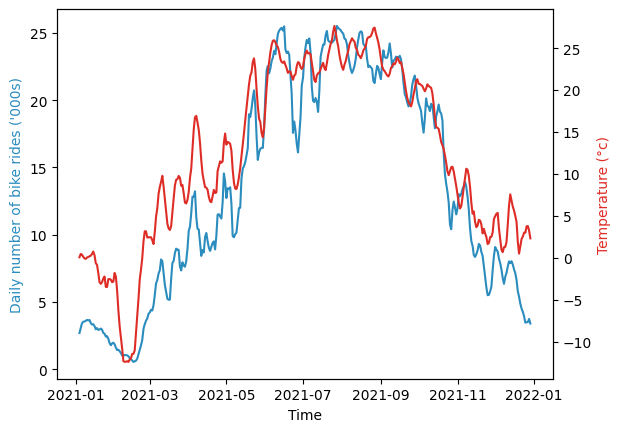

In [146]:
fig, ax1 = plt.subplots()

ax1 = sns.lineplot(rides_trend.trend, color=(43/255,140/255,190/255), legend=True)
ax2 = ax1.twinx()
sns.lineplot(temp_trend.trend, ax=ax2, color=(222/255,45/255,38/255), legend=True)

ax1.set_xlabel('Time')
ax1.set_ylabel("Daily number of bike rides ('000s)", color=(43/255,140/255,190/255))
ax2.set_ylabel('Temperature (°c)', color=(222/255,45/255,38/255))

In [170]:
rides_df_daily=pd.read_csv("raw_data/rides_df_daily_2021.csv")
rides_df_daily["date"]= pd.to_datetime(rides_df_daily["date"])

avg_weather_df=pd.read_csv("raw_data/avg_temp.csv")
avg_weather_df["date"]= pd.to_datetime(avg_weather_df["date"])

rides_df_daily = rides_df_daily.merge(avg_weather_df, on="date", how="left")

In [171]:
def plot_rides_all_bis(start_time,end_time,df_divvy,
                       timevariable):
    
    df_divvy["nb_rides"] = df_divvy["nb_rides"]/1000

    df_divvy_red = timeframe_df(df_divvy,timevariable,start_time,end_time)

    df_divvy_red = df_divvy_red.set_index('date')

    rides_trend = seasonal_decompose(df_divvy_red['nb_rides'], model='additive')
    temp_trend = seasonal_decompose(df_divvy_red['temp'], model='additive')

    ax1 = plt.subplots()

    ax1 = sns.lineplot(rides_trend.trend, color=(43/255,140/255,190/255), legend=True)
    ax2 = ax1.twinx()
    sns.lineplot(temp_trend.trend, ax=ax2, color=(222/255,45/255,38/255), legend=True)

    ax1.set_xlabel('Time')
    ax1.set_ylabel("Daily number of bike rides ('000s)", color=(43/255,140/255,190/255))
    ax2.set_ylabel('Temperature (°c)', color=(222/255,45/255,38/255))

    return ax1

In [172]:
start_time = "2021-07-01"
end_time = "2021-12-31"
timevariable="date"
weather_metric="temp"

/tmp/ipykernel_30586/4043943131.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_red = df_red[condition_2]


<AxesSubplot: xlabel='Time', ylabel="Daily number of bike rides ('000s)">

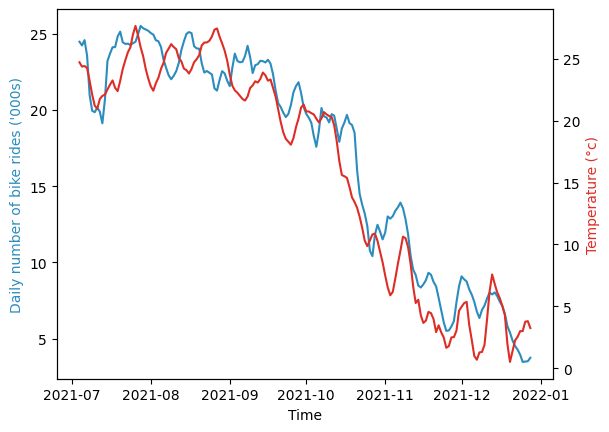

In [173]:
plot_rides_all_bis(start_time,end_time,rides_df_daily,timevariable)

In [ ]:
figure_.figure.savefig("raw_data/output.png")

In [ ]:
conf_matrix = [[4963,3],
[11,5]]

In [ ]:
conf_matrix_df = pd.DataFrame(conf_matrix,columns=["temp","nb_rides"],index=["temp","nb_rides"])
conf_matrix_df

,temp,nb_rides
temp,4963,3
nb_rides,11,5


Text(20.749999999999993, 0.5, 'Actual')

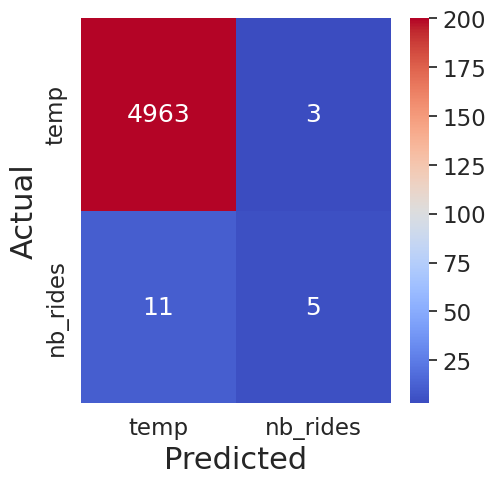

In [ ]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.5)

sns.heatmap(conf_matrix_df,
            cmap='coolwarm',
            annot=True,
            fmt='.5g',
            vmax=200)

plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
rides_df = pd.concat([divvy_q1_2021,divvy_q2_2021, divvy_q3_2021,divvy_q4_2021])
clean_divvy_df = cleaning_divvy_gen_agg(rides_df)
merged_df = merge_divvy_weather(clean_divvy_df, clean_weather_df)


/home/gdolle/code/G-Dolle/DIVVY_BIKE/divvy/ml_logic/cleaning.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [ ]:
merged_df.shape

(172569, 13)

In [ ]:
merged_df.head(5)

,geohash,hourly_data,nb_departures,nb_arrivals,ratio,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,date
0,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.20,180,20,2021-03-10
1,dp3sy,2021-03-15 22:00:00,1.0,0.0,inf,2021-03-15 22:00:00,-0.19,1009,87,8.23,110,100,2021-03-15
2,dp3sy,2021-03-20 14:00:00,1.0,0.0,inf,2021-03-20 14:00:00,4.27,1024,49,5.70,160,0,2021-03-20
3,dp3sy,2021-03-21 16:00:00,1.0,0.0,inf,2021-03-21 16:00:00,12.69,1009,35,6.70,210,20,2021-03-21
4,dp3sy,2021-03-22 21:00:00,2.0,0.0,inf,2021-03-22 21:00:00,19.25,1016,29,7.20,150,40,2021-03-22


In [ ]:
stations_df_geo = compute_geohash_stations(precision=  5)
stations_df_geo.shape

/home/gdolle/code/G-Dolle/DIVVY_BIKE/divvy/ml_logic/cleaning.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


(1422, 2)

In [ ]:
stations_df_geo.head(5)

,station_name,geohash
0,Central Ave & Harrison St,dp3w4
1,Halsted St & 59th St,dp3tt
2,Damen Ave & 51st St,dp3tu
3,Halsted St & 21st St,dp3wj
4,Michigan Ave & Madison St,dp3wq


In [ ]:
merged_df = merged_df.merge(stations_df_geo, on="geohash", how="left")
merged_df.head(6)

,geohash,hourly_data,nb_departures,nb_arrivals,ratio,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,date,station_name
0,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Altgeld Gardens
1,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Eberhart Ave & 131st St
2,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Public Rack - Ellis Ave & 132nd Pl
3,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Indiana Ave & 133rd St
4,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Public Rack - Corliss Ave & 133rd St
5,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Public Rack - Eberhart Ave & 131st St


In [ ]:
from divvy.ml_logic.data_import import get_station_data

station_df = get_station_data()
station_df= station_df[["name","lat","lon"]]
station_df.rename(columns={"name":"station_name"}, inplace=True)
station_df.head(2)

,station_name,lat,lon
0,Central Ave & Harrison St,41.872993,-87.764499
1,Halsted St & 59th St,41.787539,-87.644874


In [ ]:
merged_df = merged_df.merge(station_df, on="station_name", how="left")
merged_df.head(5)

,geohash,hourly_data,nb_departures,nb_arrivals,ratio,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,date,station_name,lat,lon
0,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Altgeld Gardens,41.656666,-87.598801
1,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Eberhart Ave & 131st St,41.658413,-87.610711
2,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Public Rack - Ellis Ave & 132nd Pl,41.655139,-87.597597
3,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Indiana Ave & 133rd St,41.653564,-87.617054
4,dp3sy,2021-03-10 03:00:00,1.0,0.0,inf,2021-03-10 03:00:00,15.38,1020,47,6.2,180,20,2021-03-10,Public Rack - Corliss Ave & 133rd St,41.653138,-87.601057


In [ ]:
heat_df = merged_df[merged_df["hourly_data"]==pd.to_datetime("2021-07-01 10:00:00")]
heat_df = merged_df[merged_df["geohash"]=="dp3wm"]
heat_df = merged_df.loc[:,["lat","lon","nb_departures"]]


heat_data = heat_df.values.tolist()


In [ ]:
from streamlit_folium import folium_static
from folium import Map, plugins

In [179]:
rides_df_daily=pd.read_csv("raw_data/rides_df_daily_2021.csv")
rides_df_daily["date"]= pd.to_datetime(rides_df_daily["date"])

avg_weather_df=pd.read_csv("raw_data/avg_temp.csv")
avg_weather_df["date"]= pd.to_datetime(avg_weather_df["date"])

rides_df_daily = rides_df_daily.merge(avg_weather_df, on="date", how="left")

In [180]:
rides_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        366 non-null    datetime64[ns]
 1   nb_rides    366 non-null    int64         
 2   temp        366 non-null    float64       
 3   pressure    366 non-null    float64       
 4   humidity    366 non-null    float64       
 5   wind_speed  366 non-null    float64       
 6   wind_deg    366 non-null    float64       
 7   clouds_all  366 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 25.7 KB


In [183]:
def timeframe_df(df,start_time,end_time):

    condition_1 = df["date"] >= pd.to_datetime(start_time)
    condition_2 = df["date"] <= pd.to_datetime(end_time)

    df_red = df[condition_1]
    df_red = df_red[condition_2]

    return df_red

In [187]:
def plot_rides_all_bis(start_time,end_time,df_divvy):

    df_divvy["nb_rides"] = df_divvy["nb_rides"]/1000

    df_divvy_red = timeframe_df(df_divvy,start_time,end_time)

    df_divvy_red = df_divvy_red.set_index('date')

    rides_trend = seasonal_decompose(df_divvy_red['nb_rides'], model='additive')
    temp_trend = seasonal_decompose(df_divvy_red['temp'], model='additive')

    fig, ax1 = plt.subplots()

    ax1 = sns.lineplot(rides_trend.trend, color=(43/255,140/255,190/255), legend=True)
    ax2 = ax1.twinx()
    sns.lineplot(temp_trend.trend, ax=ax2, color=(222/255,45/255,38/255), legend=True)

    ax1.set_xlabel('Time')
    ax1.set_ylabel("Daily number of bike rides ('000s)", color=(43/255,140/255,190/255))
    ax2.set_ylabel('Temperature (°c)', color=(222/255,45/255,38/255))

    return fig

In [188]:
start_time = "2021-07-01"
end_time = "2021-12-31"
timevariable="date"
weather_metric = "temp"

In [189]:
condition_1 = rides_df_daily["date"] >= pd.to_datetime(start_time)
df_red = rides_df_daily[condition_1]


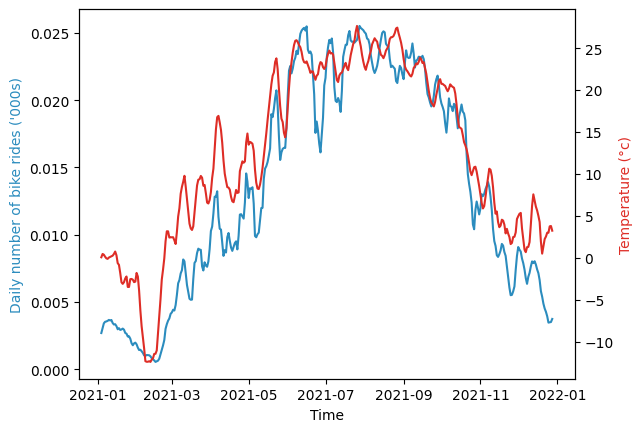

In [285]:
start_time = "2021-01-01"
end_time = "2021-12-31"
timevariable="date"
weather_metric = "temp"

fig=plot_rides_all_bis(start_time,end_time,
                       rides_df_daily)

In [191]:
rides_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        366 non-null    datetime64[ns]
 1   nb_rides    366 non-null    float64       
 2   temp        366 non-null    float64       
 3   pressure    366 non-null    float64       
 4   humidity    366 non-null    float64       
 5   wind_speed  366 non-null    float64       
 6   wind_deg    366 non-null    float64       
 7   clouds_all  366 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 33.8 KB


In [197]:
rides_df_daily["dayofweek"] = rides_df_daily['date'].dt.dayofweek

In [198]:
rides_df_daily.head()

,date,nb_rides,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,dayofweek
0,2021-01-01,0.000948,-1.328750,1021.875000,82.541667,7.308333,95.416667,85.208333,4
1,2021-01-02,0.002086,0.635417,1016.125000,89.541667,7.054167,279.583333,100.000000,5
2,2021-01-03,0.002236,0.512917,1015.458333,90.208333,4.433333,234.583333,100.000000,6
3,2021-01-04,0.002946,-2.283750,1016.375000,88.500000,6.129167,206.250000,100.000000,0
4,2021-01-05,0.003539,-0.260417,1017.375000,86.875000,5.125000,287.500000,95.416667,1


In [232]:
rides_df_daily=pd.read_csv("raw_data/rides_df_daily_2021.csv")
rides_df_daily["date"]= pd.to_datetime(rides_df_daily["date"])

avg_weather_df=pd.read_csv("raw_data/avg_temp.csv")
avg_weather_df["date"]= pd.to_datetime(avg_weather_df["date"])

rides_df_daily = rides_df_daily.merge(avg_weather_df, on="date", how="left")

rides_df_daily["dayofweek"] = rides_df_daily['date'].dt.dayofweek

In [233]:
rides_df_daily['category'] = (rides_df_daily['dayofweek'] >= 5) 
rides_df_daily["category"].replace({False:0,True:1}, inplace=True)

In [234]:
rides_df_daily.head(4)

,date,nb_rides,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,dayofweek,category
0,2021-01-01,948,-1.328750,1021.875000,82.541667,7.308333,95.416667,85.208333,4,0
1,2021-01-02,2086,0.635417,1016.125000,89.541667,7.054167,279.583333,100.000000,5,1
2,2021-01-03,2236,0.512917,1015.458333,90.208333,4.433333,234.583333,100.000000,6,1
3,2021-01-04,2946,-2.283750,1016.375000,88.500000,6.129167,206.250000,100.000000,0,0


In [235]:
test_df = rides_df_daily.groupby(by="dayofweek")["nb_rides"].mean().reset_index()


In [238]:
test_df["nb_rides"]=test_df["nb_rides"]/1000
test_df["dayofweek"].replace({0:"Monday",
                              1:"Tuesday",
                              2: "Wednesday",
                              3:"Thursday",
                              4:"Friday",
                              5:"Saturday",
                              6:"Sunday"},inplace=True)

Text(0, 0.5, "Average daily number of bike rides ('000s)")

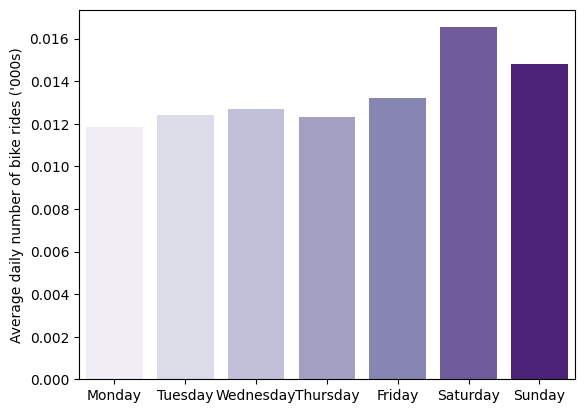

In [239]:
color =[(239,237,245),(218,218,235),(188,189,220),(158,154,200),(128,125,186),(106,81,163),(74,20,134)]


color = [tuple(item / 255 for item in my_tuple) for my_tuple in color]

ax1 = sns.barplot(x=test_df["dayofweek"],y=test_df["nb_rides"], palette=color)

ax1.set_xlabel('')
ax1.set_ylabel("Average daily number of bike rides ('000s)")

In [ ]:
rides_df_daily["dayofweek"] = rides_df_daily['date'].dt.dayofweek
rides_df_daily['category'] = (rides_df_daily['dayofweek'] >= 5)
rides_df_daily["category"].replace({False:0,True:1}, inplace=True)
test_df = rides_df_daily.groupby(by="category")["nb_rides"].mean().reset_index()

test_df["category"].replace({0:"weekdays",1:"weekends"},inplace=True)
color =[(188/255,189/255,220/255),(117/255,107/255,177/255)]

fig2, ax1 = plt.subplots()
ax1 = sns.barplot(x=test_df["category"],y=test_df["nb_rides"], palette=color)

ax1.set_xlabel('')
ax1.set_ylabel("Average daily number of bike rides ('000s)")

In [245]:
rides_df_daily=pd.read_csv("raw_data/rides_df_daily_2021.csv")
rides_df_daily["date"]= pd.to_datetime(rides_df_daily["date"])

avg_weather_df=pd.read_csv("raw_data/avg_temp.csv")
avg_weather_df["date"]= pd.to_datetime(avg_weather_df["date"])

rides_df_daily = rides_df_daily.merge(avg_weather_df, on="date", how="left")
rides_df_daily["nb_rides"]= rides_df_daily["nb_rides"]/1000


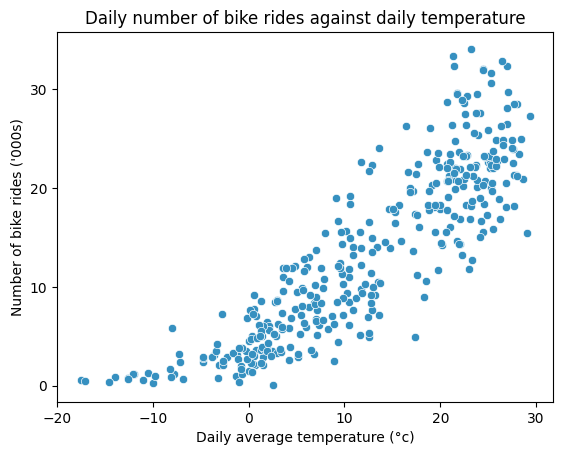

In [247]:
fig0, ax1 = plt.subplots()

ax1 = sns.scatterplot(data = rides_df_daily, x="temp",y="nb_rides", color=(54/255,144/255,192/255))
ax1.set_title("Daily number of bike rides against daily temperature")
ax1.set_xlabel("Daily average temperature (°c)")
ax1.set_ylabel("Number of bike rides ('000s)")
ax1.set_xticks(range(-20,35,10))
ax1.set_yticks(range(0,40,10))

In [248]:
divvy_q1_2021 = get_divvy_data(2021,"Q1")

divvy_q2_2021 = get_divvy_data(2021,"Q2")
divvy_q3_2021 = get_divvy_data(2021,"Q3")
divvy_q4_2021 = get_divvy_data(2021,"Q4")


rides_df = pd.concat([divvy_q1_2021,divvy_q2_2021, divvy_q3_2021,divvy_q4_2021])

In [258]:
rides_df = pd.concat([divvy_q1_2021,divvy_q2_2021, divvy_q3_2021,divvy_q4_2021])

In [259]:
rides_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,E19E6F1B8D4C42ED,electric_bike,2021-01-23 16:14:19,2021-01-23 16:24:44,California Ave & Cortez St,17660,NaN,NaN,41.900341,-87.696743,41.89,-87.72,member
1,DC88F20C2C55F27F,electric_bike,2021-01-27 18:43:08,2021-01-27 18:47:12,California Ave & Cortez St,17660,NaN,NaN,41.900333,-87.696707,41.90,-87.69,member
2,EC45C94683FE3F27,electric_bike,2021-01-21 22:35:54,2021-01-21 22:37:14,California Ave & Cortez St,17660,NaN,NaN,41.900313,-87.696643,41.90,-87.70,member
3,4FA453A75AE377DB,electric_bike,2021-01-07 13:31:13,2021-01-07 13:42:55,California Ave & Cortez St,17660,NaN,NaN,41.900399,-87.696662,41.92,-87.69,member
4,BE5E8EB4E7263A0B,electric_bike,2021-01-23 02:24:02,2021-01-23 02:24:45,California Ave & Cortez St,17660,NaN,NaN,41.900326,-87.696697,41.90,-87.70,casual


In [260]:
rides_df = rides_df[rides_df["start_station_name"].isnull()==False]
rides_df['started_at']=pd.to_datetime(rides_df['started_at'])
rides_df['hourly_data_started'] = rides_df.started_at.dt.round('60min')

rides_df = rides_df[["start_station_name","ride_id","hourly_data_started"]]
rides_df.rename(columns={"start_station_name":"station_name"}, inplace=True)

In [261]:
rides_df.head(5)

,station_name,ride_id,hourly_data_started
0,California Ave & Cortez St,E19E6F1B8D4C42ED,2021-01-23 16:00:00
1,California Ave & Cortez St,DC88F20C2C55F27F,2021-01-27 19:00:00
2,California Ave & Cortez St,EC45C94683FE3F27,2021-01-21 23:00:00
3,California Ave & Cortez St,4FA453A75AE377DB,2021-01-07 14:00:00
4,California Ave & Cortez St,BE5E8EB4E7263A0B,2021-01-23 02:00:00


In [262]:
rides_df["date"]= pd.to_datetime(rides_df["hourly_data_started"]).dt.date
rides_df["date"]= pd.to_datetime(rides_df["date"])

rides_df["nb_rides"]=1
rides_df.head(5)

,station_name,ride_id,hourly_data_started,date,nb_rides
0,California Ave & Cortez St,E19E6F1B8D4C42ED,2021-01-23 16:00:00,2021-01-23,1
1,California Ave & Cortez St,DC88F20C2C55F27F,2021-01-27 19:00:00,2021-01-27,1
2,California Ave & Cortez St,EC45C94683FE3F27,2021-01-21 23:00:00,2021-01-21,1
3,California Ave & Cortez St,4FA453A75AE377DB,2021-01-07 14:00:00,2021-01-07,1
4,California Ave & Cortez St,BE5E8EB4E7263A0B,2021-01-23 02:00:00,2021-01-23,1


In [263]:
hour_w_df = rides_df.groupby(by=["date","hourly_data_started"])["nb_rides"].sum().reset_index()
hour_w_df

,date,hourly_data_started,nb_rides
0,2021-01-01,2021-01-01 00:00:00,13
1,2021-01-01,2021-01-01 01:00:00,35
2,2021-01-01,2021-01-01 02:00:00,48
3,2021-01-01,2021-01-01 03:00:00,33
4,2021-01-01,2021-01-01 04:00:00,12
...,...,...,...
8737,2021-12-31,2021-12-31 20:00:00,211
8738,2021-12-31,2021-12-31 21:00:00,161
8739,2021-12-31,2021-12-31 22:00:00,125
8740,2021-12-31,2021-12-31 23:00:00,164


In [264]:
hour_w_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8742 entries, 0 to 8741
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 8742 non-null   datetime64[ns]
 1   hourly_data_started  8742 non-null   datetime64[ns]
 2   nb_rides             8742 non-null   int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 205.0 KB


In [265]:
hour_w_df["dayofweek"] = hour_w_df['date'].dt.dayofweek

hour_w_df['category'] = (hour_w_df['dayofweek'] >= 5)
hour_w_df["category"].replace({False:0,True:1}, inplace=True)
hour_w_df.head(5)

,date,hourly_data_started,nb_rides,dayofweek,category
0,2021-01-01,2021-01-01 00:00:00,13,4,0
1,2021-01-01,2021-01-01 01:00:00,35,4,0
2,2021-01-01,2021-01-01 02:00:00,48,4,0
3,2021-01-01,2021-01-01 03:00:00,33,4,0
4,2021-01-01,2021-01-01 04:00:00,12,4,0


In [266]:
hour_w_df.category.value_counts()

0    6249
1    2493
Name: category, dtype: int64

In [269]:
hour_w_df["hour"] = hour_w_df['hourly_data_started'].dt.hour
hour_w_df.head(5)

,date,hourly_data_started,nb_rides,dayofweek,category,hour
0,2021-01-01,2021-01-01 00:00:00,13,4,0,0
1,2021-01-01,2021-01-01 01:00:00,35,4,0,1
2,2021-01-01,2021-01-01 02:00:00,48,4,0,2
3,2021-01-01,2021-01-01 03:00:00,33,4,0,3
4,2021-01-01,2021-01-01 04:00:00,12,4,0,4


In [273]:
hour_w_agg_df = hour_w_df.groupby(by=["category","hour"])["nb_rides"].mean().reset_index()
hour_w_agg_df

,category,hour,nb_rides
0,0,0,158.003831
1,0,1,83.644788
2,0,2,49.696498
3,0,3,26.517647
4,0,4,24.077220
5,0,5,51.088462
6,0,6,203.164751
7,0,7,453.275862
8,0,8,672.022989
9,0,9,559.417625


In [282]:
hour_w_agg_df.to_csv("raw_data/hourly_avg_rides_2021.csv", index=False)

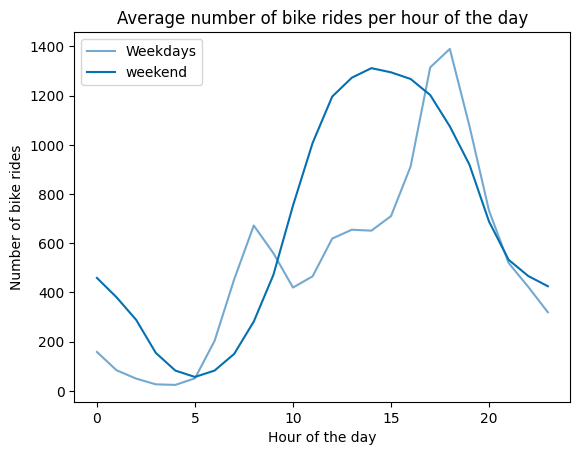

In [284]:
figXX, ax1 = plt.subplots()


ax1 = sns.lineplot(x=hour_w_agg_df.loc[hour_w_agg_df["category"]==0,"hour"],
             y=hour_w_agg_df.loc[hour_w_agg_df["category"]==0,"nb_rides"],
             color=(116/255,169/255,207/255), label="Weekdays")

ax2 = sns.lineplot(x=hour_w_agg_df.loc[hour_w_agg_df["category"]==1,"hour"],
             y=hour_w_agg_df.loc[hour_w_agg_df["category"]==1,"nb_rides"],
             color=(5/255,112/255,176/255),
             label="weekend")


ax1.set_title('Average number of bike rides per hour of the day')
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel("Number of bike rides")
ax1.legend()


In [286]:
rides_df_daily=pd.read_csv("raw_data/rides_df_daily_2021.csv")
rides_df_daily["date"]= pd.to_datetime(rides_df_daily["date"])

avg_weather_df=pd.read_csv("raw_data/avg_temp.csv")
avg_weather_df["date"]= pd.to_datetime(avg_weather_df["date"])

rides_df_daily = rides_df_daily.merge(avg_weather_df, on="date", how="left")
rides_df_daily["nb_rides"]= rides_df_daily["nb_rides"]/1000

In [288]:
rides_df_daily = rides_df_daily.set_index('date')

rides_trend = seasonal_decompose(rides_df_daily['nb_rides'], model='additive')
temp_trend = seasonal_decompose(rides_df_daily['temp'], model='additive')



In [291]:
test_df = pd.DataFrame(rides_trend.trend)
test_df.rename(columns={"trend":"nb_rides"}, inplace=True)

In [292]:
test_df_2 = pd.DataFrame(temp_trend.trend)
test_df_2.rename(columns={"trend":"temp"}, inplace=True)

In [293]:
test_df = test_df.merge(test_df_2, on="date", how="left")

In [294]:
test_df

,nb_rides,temp
date,,
2021-01-01,NaN,NaN
2021-01-02,NaN,NaN
2021-01-03,NaN,NaN
2021-01-04,2.700286,0.070000
2021-01-05,3.065857,0.467619
...,...,...
2021-12-28,3.746857,3.241250
2021-12-29,3.404714,2.326667
2021-12-30,NaN,NaN


In [296]:
test_df.to_csv("raw_data/rides_temp_trend_2021.csv")

In [302]:
test_df_bis = pd.read_csv("raw_data/rides_temp_trend_2021.csv")
test_df_bis["date"]= pd.to_datetime(test_df_bis["date"])
test_df_bis = test_df_bis.set_index("date", drop=True)
test_df_bis

,nb_rides,temp
date,,
2021-01-01,NaN,NaN
2021-01-02,NaN,NaN
2021-01-03,NaN,NaN
2021-01-04,2.700286,0.070000
2021-01-05,3.065857,0.467619
...,...,...
2021-12-28,3.746857,3.241250
2021-12-29,3.404714,2.326667
2021-12-30,NaN,NaN


Text(0, 0.5, 'Temperature (°c)')

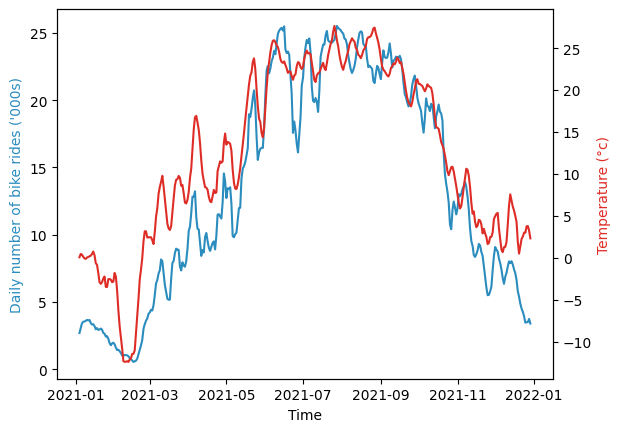

In [303]:
fig, ax1 = plt.subplots()

ax1 = sns.lineplot(test_df_bis.nb_rides, color=(43/255,140/255,190/255), legend=True)
ax2 = ax1.twinx()
sns.lineplot(test_df_bis.temp, ax=ax2, color=(222/255,45/255,38/255), legend=True)

ax1.set_xlabel('Time')
ax1.set_ylabel("Daily number of bike rides ('000s)", color=(43/255,140/255,190/255))
ax2.set_ylabel('Temperature (°c)', color=(222/255,45/255,38/255))